In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import requests
import math

In [2]:
np.random.seed(1234)
torch.manual_seed(1234)
DEVICE = torch.device("cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


##### **DATASET MODELLING**

In [3]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text
print(f"Total Characters: {len(text)}")
print(f"First 100 Characters:\n{repr(text[:100])}")

Total Characters: 1115394
First 100 Characters:
'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'


In [4]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"Vocab Size: {vocab_size}")
print(f"Characters: {repr(''.join(chars[:20])) + '...'}")

Vocab Size: 65
Characters: "\n !$&',-.3:;?ABCDEFG"...


In [5]:
# Create character mappings
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

In [6]:
data = torch.tensor([char_to_idx[ch] for ch in text], dtype=torch.long)
print(f"Data Tensor Shape: {data.shape}")

Data Tensor Shape: torch.Size([1115394])


In [7]:
n = len(data)
train_size = int(0.9 * n)
val_size = int(0.05 * n)
train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]
print(f"Training tokens: {len(train_data)} ({len(train_data)/n*100:.1f}%)")
print(f"Validation tokens: {len(val_data)} ({len(val_data)/n*100:.1f}%)")
print(f"Test tokens: {len(test_data)} ({len(test_data)/n*100:.1f}%)")

Training tokens: 1003854 (90.0%)
Validation tokens: 55769 (5.0%)
Test tokens: 55771 (5.0%)


In [8]:
class CharDataset(Dataset):
    """
        Character-level dataset for language modeling.
        Returns sequences of length seq_len with targets shifted by 1.
    """
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len
    def __len__(self):
        return len(self.data) // self.seq_len
    def __getitem__(self, idx):
        start = idx * self.seq_len
        end = start + self.seq_len + 1
        chunk = self.data[start:end]
        
        x = chunk[:-1]
        y = chunk[1:]
        return x, y

In [9]:
SEQ_LEN = 128
BATCH_SIZE = 64
train_ds = CharDataset(train_data, SEQ_LEN)
val_ds = CharDataset(val_data, SEQ_LEN)
test_ds = CharDataset(test_data, SEQ_LEN)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 123
Number of validation batches: 7
Number of test batches: 7


##### **TASK 1: TINY TRANSFORMER LM**

In [10]:
class MultiHeadSelfAttention(nn.Module):
    """
        Multi-head self-attention with causal masking.
        Args:
            d_model: Dimension of the model.
            n_heads: Number of attention heads.
            seq_len: Length of the input sequences.
    """
    def __init__(self, d_model=192, n_heads=3, seq_len=SEQ_LEN):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        
        self.qkv_proj = nn.Linear(d_model, 3 * d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        
        # Causal mask: upper triangular matrix of -inf
        self.register_buffer(
            "causal_mask",
            torch.triu(torch.ones(seq_len, seq_len) * float('-inf'), diagonal=1)
        )
        
    def forward(self, x):
        """
            Forward pass for multi-head self-attention.
            Args:
                x: Input tensor of shape (batch_size, seq_len, d_model)
            Returns:
                Output tensor of shape (batch_size, seq_len, d_model)
        """
        batch_size, seq_len, d_model = x.shape
        
        # Compute Q, K, V projections
        qkv = self.qkv_proj(x)  
        qkv = qkv.reshape(batch_size, seq_len, 3, self.n_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Scaled dot-product attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        # Apply causal mask
        scores = scores + self.causal_mask[:seq_len, :seq_len]
        # Softmax over the last dimension for attention weights
        attn_weights = F.softmax(scores, dim=-1)
        # Apply attention to values
        attn_output = torch.matmul(attn_weights, v)
        # Concatenate heads
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.reshape(batch_size, seq_len, d_model)
        # Output projection
        output = self.out_proj(attn_output)
        return output

In [11]:
class FeedForward(nn.Module):
    """
        Position-wise Feed-Forward Network.
        FFN(x) = GELU(xW1 + b1)W2 + b2
        Args:
            d_model: i/o dimension
            d_ff: hidden dimension
    """
    def __init__(self, d_model=192, d_ff=768):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        """
            Forward pass for Feed-Forward Network.
            Args:
                x: Input tensor of shape (batch_size, seq_len, d_model)
            Returns:
                Output tensor of shape (batch_size, seq_len, d_model)
        """
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

In [12]:
class TransformerBlock(nn.Module):
    """
        Single Transformer block with pre-norm architecture
        Structure:
        1. LayerNorm -> Multi-Head Self-Attention -> Residual
        2. LayerNorm -> Feed-Forward Network -> Residual
        Args:
            d_model: Dimension of the model.
            n_heads: Number of attention heads.
            d_ff: Dimension of the feed-forward network.
            seq_len: Length of the input sequences.
    """
    def __init__(self, d_model=192, n_heads=3, d_ff=768, seq_len=SEQ_LEN):
        super().__init__()
        # Layer normalization (pre-norm)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        # Multi-head self-attention
        self.attn = MultiHeadSelfAttention(d_model, n_heads, seq_len)
        # Feed-forward network
        self.ffn = FeedForward(d_model, d_ff)
        
    def forward(self, x):
        """
            Forward pass for Transformer block.
            Args:
                x: Input tensor of shape (batch_size, seq_len, d_model)
            Returns:
                Output tensor of shape (batch_size, seq_len, d_model)
        """
        x = x + self.attn(self.ln1(x))  # Residual connection
        x = x + self.ffn(self.ln2(x))   # Residual connection
        return x

In [13]:
class TinyTransformerLM(nn.Module):
    """
        Tiny Transformer Language Model for character-level prediction.
        Architecture:
        - Token Embedding
        - Sinusoidal Positional Encoding
        - 2 Transformer Blocks
        - Language Modeling Head
        Args:
            vocab_size: Size of the vocabulary.
            d_model: Dimension of the model.
            n_heads: Number of attention heads.
            d_ff: Dimension of the feed-forward network.
            n_blocks: Number of Transformer blocks.
            seq_len: Length of the input sequences.
    """
    def __init__(self, vocab_size, d_model=192, n_heads=3, d_ff=768, n_blocks=2, seq_len=SEQ_LEN):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.register_buffer(
            "pos_encoding",
            self._create_sinusoidal_positions(seq_len, d_model)
        )
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, d_ff, seq_len) for _ in range(n_blocks)
        ])
        self.lm_head = nn.Linear(d_model, vocab_size)
        self._init_weights()
        
    def _create_sinusoidal_positions(self, seq_len, d_model):
        """
            Create sinusoidal positional encodings.
        """
        position = torch.arange(seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(seq_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe
    
    def _init_weights(self):
        """
            Initialize weights of the model, using Xavier initialization.
        """
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0, std=0.02)
                
    def forward(self, x):
        """
            Forward pass for Tiny Transformer LM.
            Args:
                x: Input tensor of shape (batch_size, seq_len)
            Returns:
                Logits tensor of shape (batch_size, seq_len, vocab_size)
        """
        batch_size, seq_len = x.shape
        
        token_emb = self.token_embedding(x)  
        pos_emb = self.pos_encoding[:seq_len, :]
        x = token_emb + pos_emb
        
        for block in self.blocks:
            x = block(x)
        
        logits = self.lm_head(x)
        return logits
    
    def generate(self, context, max_new_tokens, temperature=1.0, top_k=None, top_p=None):
        """
            Generate text autoregressively.
            Args:
                context: Input tensor of shape (batch, context_len)
                max_new_tokens: Number of tokens to generate.
                temperature: Sampling temperature.
                top_k: If specified, use top-k sampling.
                top_p: If specified, use top_p sampling.
            Returns:
                Generated tensor of shape (batch, context_len + max_new_tokens)
        """
        self.eval()
        with torch.no_grad():
            for _ in range(max_new_tokens):
                # Crop context if longer than seq_len
                context_crop = context if context.size(1) <= self.seq_len else context[:, -self.seq_len:]
                
                # Get predictions
                logits = self(context_crop)
                logits = logits[:, -1, :] 
                logits = logits / temperature
                
                if top_k is not None:
                    v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                    logits[logits < v[:, [-1]]] = float('-inf')
                    
                if top_p is not None:
                    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                    sorted_indices_to_remove = cumulative_probs > top_p
                    sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
                    sorted_indices_to_remove[:, 0] = False
                    indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                    logits[indices_to_remove] = float('-inf')
                    
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            context = torch.cat([context, next_token], dim=1)
            
        return context

In [14]:
model = TinyTransformerLM(vocab_size=vocab_size, d_model=192, n_heads=3, d_ff=768, n_blocks=2, seq_len=SEQ_LEN).to(DEVICE)
print(model)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

TinyTransformerLM(
  (token_embedding): Embedding(65, 192)
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (ln1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadSelfAttention(
        (qkv_proj): Linear(in_features=192, out_features=576, bias=True)
        (out_proj): Linear(in_features=192, out_features=192, bias=True)
      )
      (ffn): FeedForward(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
      )
    )
  )
  (lm_head): Linear(in_features=192, out_features=65, bias=True)
)
Total Parameters: 914753
Trainable Parameters: 914753


In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01, betas=(0.9, 0.95))
criterion = nn.CrossEntropyLoss()

In [16]:
def train_epoch(model, train_loader, optimizer, criterion):
    """
        Train the model for one epoch.
    """
    model.train()
    total_loss = 0
    for batch_idx, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader), desc="Training"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    return avg_loss

In [17]:
def evaluate(model, data_loader, criterion):
    """
        Evaluate the model on validation/test data
    """
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in tqdm(data_loader, total=len(data_loader), desc="Evaluating"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = criterion(logits.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    return avg_loss

In [18]:
EPOCHS = 3
history = {
    "train_loss": [],
    "val_loss": []
}

In [19]:
for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Evaluating: 100%|██████████| 7/7 [00:00<00:00, 13.51it/s]


Epoch 1/3 | Train Loss: 3.2517 | Val Loss: 2.9342


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  9.39it/s]


Epoch 2/3 | Train Loss: 2.7199 | Val Loss: 2.5972


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]

Epoch 3/3 | Train Loss: 2.5652 | Val Loss: 2.5325


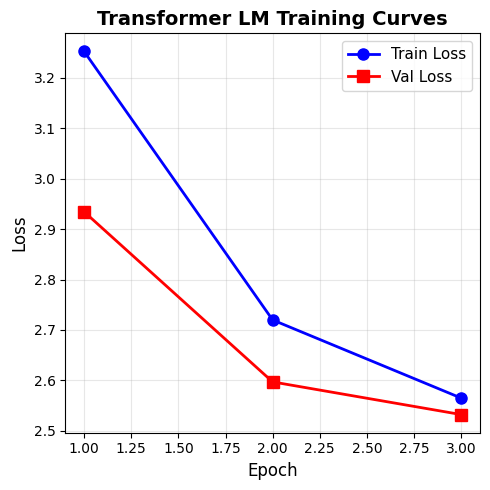

In [20]:
plt.figure(figsize=(5, 5))
plt.plot(range(1, EPOCHS + 1), history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=8)
plt.plot(range(1, EPOCHS + 1), history['val_loss'], 'r-s', label='Val Loss', linewidth=2, markersize=8)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Transformer LM Training Curves', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

##### **TASK 2: TRANSFORMER PERPLEXITY**

In [21]:
# Calculating perplexity per epoch
for epoch in range(1, EPOCHS + 1):
    val_loss = history['val_loss'][epoch - 1]
    val_ppl = math.exp(val_loss)
    print(f"Epoch {epoch}/{EPOCHS} | Validation Loss : {val_loss:.4f} | Validation Perplexity: {val_ppl:.4f}")

Epoch 1/3 | Validation Loss : 2.9342 | Validation Perplexity: 18.8059
Epoch 2/3 | Validation Loss : 2.5972 | Validation Perplexity: 13.4258
Epoch 3/3 | Validation Loss : 2.5325 | Validation Perplexity: 12.5846


##### **TASK 3: DECODING STRATEGIES**

In [22]:
prompt_text = text[train_size:train_size + 64]
print(f"Prompt Text:\n{repr(prompt_text)}\n")

Prompt Text:
'?\n\nGREMIO:\nGood morrow, neighbour Baptista.\n\nBAPTISTA:\nGood morr'



In [23]:
prompt_tokens = torch.tensor([char_to_idx[ch] for ch in prompt_text], dtype=torch.long).unsqueeze(0).to(DEVICE)
n_new_tokens = 200
temperature = 1.0

In [24]:
print("STRATEGY 1: Greedy Sampling")
model.eval()
with torch.no_grad():
    context = prompt_tokens.clone()
    for _ in range(n_new_tokens):
        context_crop = context if context.size(1) <= SEQ_LEN else context[:, -SEQ_LEN:]
        logits = model(context_crop)
        logits = logits[:, -1, :]  
        logits = logits / temperature
        next_token = torch.argmax(logits, dim=-1, keepdim=True)
        context = torch.cat([context, next_token], dim=1)
        
greedy_output = context[0].cpu().numpy()
generated_text_greedy = ''.join([idx_to_char[idx] for idx in greedy_output])
print(f"Generated text ({len(greedy_output)} chars):\n{generated_text_greedy}\n")

STRATEGY 1: Greedy Sampling
Generated text (264 chars):
?

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morr and the and the t the t t t the t t t the t the the t t t t t and t t and and t an an t and an t t t an t t t t an an an t are are an are t t and t t t t and t t t anoure t at at t t t t t t t t are 



In [25]:
print("STRATEGY 2: Top-K Sampling (k=20)")
topk_output = model.generate(prompt_tokens, max_new_tokens=n_new_tokens, temperature=temperature, top_k=20)
topk_text = ''.join([idx_to_char[idx] for idx in topk_output[0].cpu().numpy()])
print(f"Generated text ({len(topk_output[0])} chars):\n{topk_text}\n")

STRATEGY 2: Top-K Sampling (k=20)
Generated text (65 chars):
?

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morr 



In [26]:
print("STRATEGY 3: Top-P Sampling (p=0.9)")
topp_output = model.generate(prompt_tokens, max_new_tokens=n_new_tokens, temperature=temperature, top_p=0.9)
topp_text = ''.join([idx_to_char[idx] for idx in topp_output[0].cpu().numpy()])
print(f"Generated text ({len(topp_output[0])} chars):\n{topp_text}\n")

STRATEGY 3: Top-P Sampling (p=0.9)
Generated text (65 chars):
?

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morr 



##### **TRADE-OFF SUMMARY FOR THE DECODING STRATEGIES**
1. **Greedy** : Poor fluency, almost no diversity.
2. **TOP-K**  : Better fluency, but still limited diversity.
3. **TOP-P**  : Better fluency, but limited diversity. (the output is almost as same as TOP-K)